In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from CybORG import CybORG
from CybORG.Simulator.Scenarios.DroneSwarmScenarioGenerator import DroneSwarmScenarioGenerator
from CybORG.Agents.SimpleAgents.RedDroneWorm import RedDroneWormAgent
from CybORG.Agents.Wrappers import PettingZooParallelWrapper

import torch
from torch_geometric.utils import from_networkx
from ipaddress import IPv4Address
import random
import logging
from torch_geometric.loader import DataLoader
import pickle

# Train GCN

### Load Data

In [4]:
filename = './Data/node'
# testfile = '../Data/testmulti'



combined_dataset = torch.load(f'{filename}.pt', weights_only=False)
# testset = torch.load(f'{testfile}.pt', weights_only=False)



# combined_dataset = dataset + testset
# print(f"Combined dataset length: {len(combined_dataset)}")
random.shuffle(combined_dataset)

size = len(combined_dataset)
train_size = int(0.7 * size)

dataset = combined_dataset[:train_size]
testset = combined_dataset[train_size:]
print(f"Train dataset length: {len(dataset)}")
print(f"Test dataset length: {len(testset)}")

Train dataset length: 14000
Test dataset length: 6000


In [5]:
import torch
from torch_geometric.datasets import TUDataset
from pprint import pprint
import random


for data in dataset:
    delattr(data, 'feature')


print(len(dataset))
data = dataset[10]  # Get the first graph object.

print()
print(data)
print('=============================================================')



# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


14000

Data(edge_index=[2, 78], num_nodes=18, x=[18, 110], y=[18])
Number of nodes: 18
Number of edges: 78
Average node degree: 4.33
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
import random

# random.shuffle(dataset)
# random.shuffle(testset)
# train_dataset = dataset[:12000]
# test_dataset = dataset[12000:]

# size = len(dataset)
# size = size - size//4

train_dataset = dataset
test_dataset = testset


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 14000
Number of test graphs: 6000


In [7]:
for data in dataset:
    if data.size(1) != 18:
        print(f"Warning: Data shape {data.shape} is not 18")

In [8]:
# test_dataset = torch.load(f"test_gl_selected.pt", weights_only=False)
# train_dataset = torch.load(f"train_gl_selected.pt", weights_only=False)

test_dataset = testset
train_dataset = dataset

print(f'Number of features in train dataset: {train_dataset[0].x.shape[1]}')

# Determine the number of classes in the dataset
unique_classes = set()
for t in train_dataset:
    unique_classes.update(t.y.unique().cpu().numpy())
num_classes = len(unique_classes)
print(f"Number of classes detected: {num_classes}")

# Test dataset statistics
test_total_nodes = 0
test_class_counts = {i: 0 for i in range(num_classes)}

for t in test_dataset:
    test_total_nodes += t.y.size(0)
    for class_idx in range(num_classes):
        test_class_counts[class_idx] += (t.y == class_idx).sum().item()

# Train dataset statistics
train_total_nodes = 0
train_class_counts = {i: 0 for i in range(num_classes)}

for t in train_dataset:
    train_total_nodes += t.y.size(0)
    for class_idx in range(num_classes):
        train_class_counts[class_idx] += (t.y == class_idx).sum().item()

# Print statistics with class labels
class_labels = ["Not Compromised", "Compromised", "Highly Compromised"] if num_classes == 3 else [f"Class {i}" for i in range(num_classes)]

print('--------------Train--------------')
print(f'\033[1mTotal nodes: \033[0m{train_total_nodes}')
for i in range(num_classes):
    percentage = train_class_counts[i]/train_total_nodes if train_total_nodes > 0 else 0
    print(f'\033[1mPercent of {class_labels[i]}: \033[0m{percentage:.4f} ({train_class_counts[i]} nodes)')

print('\n--------------Test--------------')
print(f'\033[1mTotal nodes: \033[0m{test_total_nodes}')
for i in range(num_classes):
    percentage = test_class_counts[i]/test_total_nodes if test_total_nodes > 0 else 0
    print(f'\033[1mPercent of {class_labels[i]}: \033[0m{percentage:.4f} ({test_class_counts[i]} nodes)')

# Print class distribution visualization if desired
print("\nClass distribution:")
max_bar_length = 50  # maximum bar length in characters
for i in range(num_classes):
    train_pct = train_class_counts[i]/train_total_nodes if train_total_nodes > 0 else 0
    bar_length = int(train_pct * max_bar_length)
    print(f"{class_labels[i]}: {'█' * bar_length} {train_pct:.2%}")

Number of features in train dataset: 110
Number of classes detected: 3
--------------Train--------------
Total nodes: 252000
Percent of Not Compromised: 0.3522 (88745 nodes)
Percent of Compromised: 0.0153 (3850 nodes)
Percent of Highly Compromised: 0.6326 (159405 nodes)

--------------Test--------------
Total nodes: 108000
Percent of Not Compromised: 0.3507 (37872 nodes)
Percent of Compromised: 0.0159 (1715 nodes)
Percent of Highly Compromised: 0.6335 (68413 nodes)

Class distribution:
Not Compromised: █████████████████ 35.22%
Compromised:  1.53%
Highly Compromised: ███████████████████████████████ 63.26%


### Train

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Specify device manually
use_gpu = True # Set to False to use CPU
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# DataLoader (ensure `train_dataset` and `test_dataset` are loaded correctly)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = len(train_dataset[0].x[0])

# Define the GCN model for node classification
class GCN(torch.nn.Module):
    def __init__(self, input_dim=input_dim,hidden_channels=32,num_classes=3):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)  # 2 classes: compromised or not

    def forward(self, x, edge_index, batch=None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # 2. Node-level classification
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=32)
print(model)

Using device: cpu
GCN(
  (conv1): GCNConv(110, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
from sklearn.metrics import precision_score, recall_score
num_classes = 3
# Initialize the model, optimizer, and loss function
model = GCN(hidden_channels=64, num_classes=num_classes).to(device)  # Make sure GCN uses correct number of classes
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Calculate class weights inversely proportional to class frequencies
class_weights = []
for class_idx in range(num_classes):
    # Get counts for this class
    class_count = train_class_counts[class_idx]
    # Calculate weight (inversely proportional to frequency)
    if class_count > 0:
        weight = train_total_nodes / (num_classes * class_count)
    else:
        weight = 1.0
    class_weights.append(weight)

# Normalize weights
class_weights = [w / sum(class_weights) * num_classes for w in class_weights]
class_weights_tensor = torch.tensor(class_weights, device=device)

print(f"Class weights: {class_weights}")

# Use weighted cross entropy loss
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

losses = []  # Training losses
test_losses = []  # Test losses
accs = []  # Test accuracies
precisions = []  # Test precisions
recalls = []  # Test recalls
train_accs = []  # Training accuracies

# Define the training loop
def train():
    model.train()
    total_loss = 0
    total_correct = 0
    total_nodes = 0

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)  # Move batch data to GPU
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        total_loss += loss.item() * data.num_nodes  # Accumulate loss for this epoch.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        
        # Calculate accuracy for node predictions
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct = int((pred == data.y).sum())  # Check against ground-truth labels.
        total_correct += correct
        total_nodes += data.num_nodes
    
    avg_loss = total_loss / total_nodes  # Calculate average loss per node
    acc = total_correct / total_nodes  # Calculate accuracy per node
    train_accs.append(acc)  # Append accuracy to the list.
    losses.append(avg_loss)  # Append the average loss to the list.

# Define the testing loop
def test(loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_nodes = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation.
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)  # Move batch data to GPU
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)  # Compute the loss for the batch.
            total_loss += loss.item() * data.num_nodes  # Accumulate test loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct = int((pred == data.y).sum())  # Check against ground-truth labels.
            total_correct += correct
            total_nodes += data.num_nodes

            # Collect predictions and true labels for precision and recall
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / total_nodes  # Calculate average loss per node
    test_losses.append(avg_loss)  # Append the average test loss to the list.
    acc = total_correct / total_nodes  # Calculate accuracy per node
    accs.append(acc)  # Append accuracy to the list.

    # Compute precision and recall
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

    return acc, avg_loss, precision, recall

# Training and testing loop
for epoch in range(1, 1001):
    train()
    test_acc, test_loss, precision, recall = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Class weights: [0.1219146652948985, 2.810212200414485, 0.06787313429061677]
Epoch: 001, Train Loss: 2.5294, Test Loss: 0.8854, Train Acc: 0.4549, Test Acc: 0.6686, Precision: 0.5515, Recall: 0.5953
Epoch: 002, Train Loss: 1.2331, Test Loss: 0.8581, Train Acc: 0.5307, Test Acc: 0.6389, Precision: 0.5663, Recall: 0.6030
Epoch: 003, Train Loss: 1.0449, Test Loss: 0.8516, Train Acc: 0.5567, Test Acc: 0.6319, Precision: 0.5730, Recall: 0.6115
Epoch: 004, Train Loss: 0.9793, Test Loss: 0.8441, Train Acc: 0.5720, Test Acc: 0.6151, Precision: 0.5819, Recall: 0.6196
Epoch: 005, Train Loss: 0.9385, Test Loss: 0.8352, Train Acc: 0.5831, Test Acc: 0.6072, Precision: 0.5874, Recall: 0.6271


### Graphs

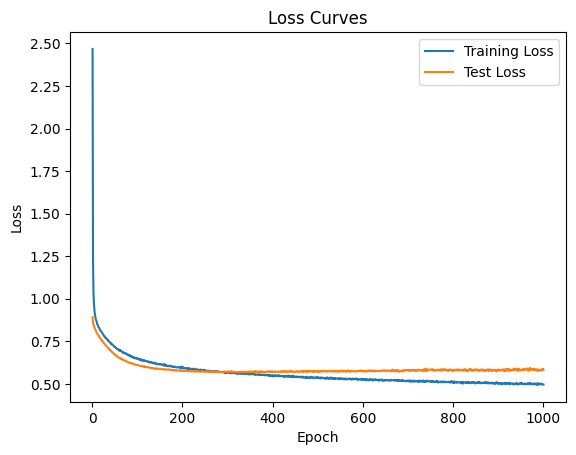

In [231]:
# Plot the loss curve
plt.plot(range(1, 1001), losses, label='Training Loss')
plt.plot(range(1,1001), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.savefig('../Data/loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Max accuracy: 0.7678981481481482


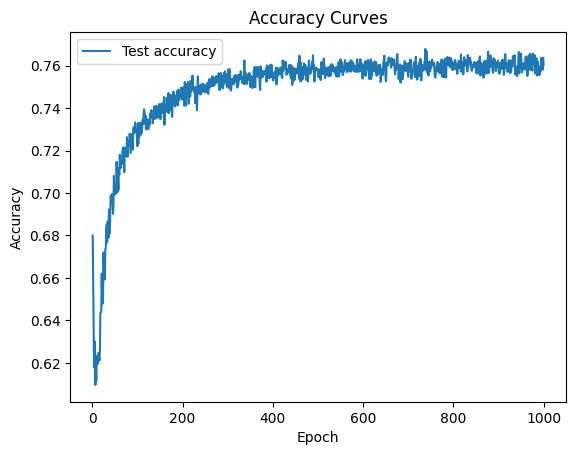

In [230]:
plt.plot(range(1, 1001), accs, label='Test accuracy')
# plt.plot(range(1, 101), train_accs, label='Train accuracy')
print(f'Max accuracy: {max(accs)}')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
# plt.savefig('../Data/accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()


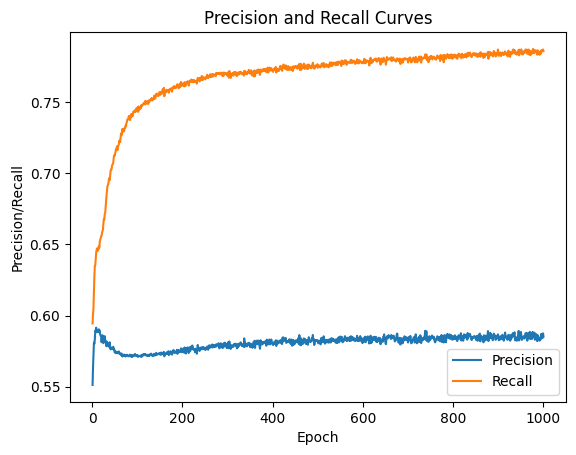

In [232]:
plt.plot(range(1, 1001), precisions, label='Precision')
plt.plot(range(1, 1001), recalls, label='Recall')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Curves')
plt.savefig('../Data/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()